In [ ]:
### Packages and  data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
matplotlib.rcParams['pdf.fonttype'] = 42

#colors
dic_color = {}
with open("/home/mouren/Data/variants/tcga_MC3/colors_tcga_rgb_dic.tsv") as f:
    for line in f:
        line_values = line.strip().split('\t')
        label = line_values[0]
        red, green, blue = map(float, line_values[1:4])
        dic_color[label] = (red, green, blue, 1.0) 

#cancers id 
dic_id_cancer = {}
with open("/home/mouren/Data/variants/tcga_MC3/tcga_snp_exonhancers_hg19.tsv")as f:
    for line in f:
        if line.strip().split()[10] not in dic_id_cancer:
            dic_id_cancer[line.strip().split()[10]] = [line.strip().split()[11]]
        else:
            dic_id_cancer[line.strip().split()[10]].append(line.strip().split()[11])

#fabian id 
dic_fabian_id = {}
with open("/home/mouren/Data/variants/tcga_MC3/snpId_fabianFormat_dic.tsv")as f:
    for line in f:
        id_list = line.strip().split('\t')
        id_list_without_first = id_list[1:]
        dic_fabian_id[line.strip().split('\t')[0]] = id_list_without_first

# Create dictionnary of snp Id with list of score (remove fabian format id) 
dic_snp_score = {}
with open("/home/mouren/Data/variants/tcga_MC3/fabian/fabian_precise_snp_tcga_full_list_onlyJaspar.tsv")as f:
    for line in f:
        score_list = line.strip().split('\t')
        score_list_without_first = score_list[1:]
        true_id = dic_fabian_id[line.strip().split('\t')[0]]
        if len(true_id) > 1:
            for i in true_id:
                dic_snp_score[i] = score_list_without_first
        else:
            dic_snp_score[true_id[0]] = score_list_without_first

In [2]:
### Number of snp per cancer
cancer_dic_total = {}
cancer_dic_syn = {}
dic_cancer_effect_sum_GAIN = {}
dic_cancer_effect_sum_LOSS = {}

with open( "/home/mouren/Data/variants/tcga_MC3/tcga_snp_exonhancers_raw_uniques.tsv")as f:
    for line in f:
        # compute total of snp in cancer
        if line.strip().split()[6] not in cancer_dic_total:
            cancer_dic_total[line.strip().split()[6]] = 1
        else:
            cancer_dic_total[line.strip().split()[6]] += 1

        #synonymous
        if line.strip().split()[5] == "Silent":
            if line.strip().split()[6] not in cancer_dic_syn:
                cancer_dic_syn[line.strip().split()[6]] = 1
            else:
                cancer_dic_syn[line.strip().split()[6]] += 1

        ##get fabion of snp
        id = line.strip().split()[0]+":"+line.strip().split()[2]+line.strip().split()[3]+">"+line.strip().split()[4]
        true_id = dic_fabian_id[id]
        cancer = line.strip().split()[6]

        if cancer not in dic_cancer_effect_sum_GAIN :
            dic_cancer_effect_sum_GAIN[cancer] = [0,0,0] #weak_gain medium_gain strong_gain medium_gain
            dic_cancer_effect_sum_LOSS[cancer] = [0,0,0] #weak_loss medium_loss strong_loss
        
        try:
            compute = dic_snp_score[true_id[0]]
        except Exception:
            continue
        
        float_values = [float(x) for x in compute]
        score = max(float_values, key=abs)
        if score > 0.66:
            dic_cancer_effect_sum_GAIN[cancer][2] += 1
        elif score > 0.33:
            dic_cancer_effect_sum_GAIN[cancer][1] += 1
        elif score > 0:
            dic_cancer_effect_sum_GAIN[cancer][0] += 1
        elif score < -0.66:
            dic_cancer_effect_sum_LOSS[cancer][2] -= 1
        elif score < -0.33:
            dic_cancer_effect_sum_LOSS[cancer][1] -= 1
        else:
            dic_cancer_effect_sum_LOSS[cancer][0] -= 1

In [3]:
#re-order dict and colors based on order of patient graph 
#Order for patient graph 
category_order = ['UVM', 'THCA', 'TGCT', 'PCPG', 'LAML', 'THYM', 'LGG', 'KICH', 'ACC',
       'MESO', 'PRAD', 'PAAD', 'BRCA', 'CHOL', 'KIRC', 'SARC', 'UCS', 'GBM',
       'KIRP', 'OV', 'UCEC', 'LIHC', 'DLBC', 'CESC', 'READ', 'HNSC', 'ESCA',
       'STAD', 'COAD', 'BLCA', 'LUAD', 'LUSC', 'SKCM']

category_order.reverse()

order_color = [dic_color[i] for i in category_order]
sorted_total = [cancer_dic_total[label] for label in category_order]
sorted_syn = [cancer_dic_syn[label] for label in category_order]

dic_cancer_effect_sum_GAIN_reorder = {key: dic_cancer_effect_sum_GAIN[key] for key in category_order} #desired_order_exonhancers
dic_cancer_effect_sum_LOSS_reorder = {key: dic_cancer_effect_sum_LOSS[key] for key in category_order} # desired_order_exonhancers

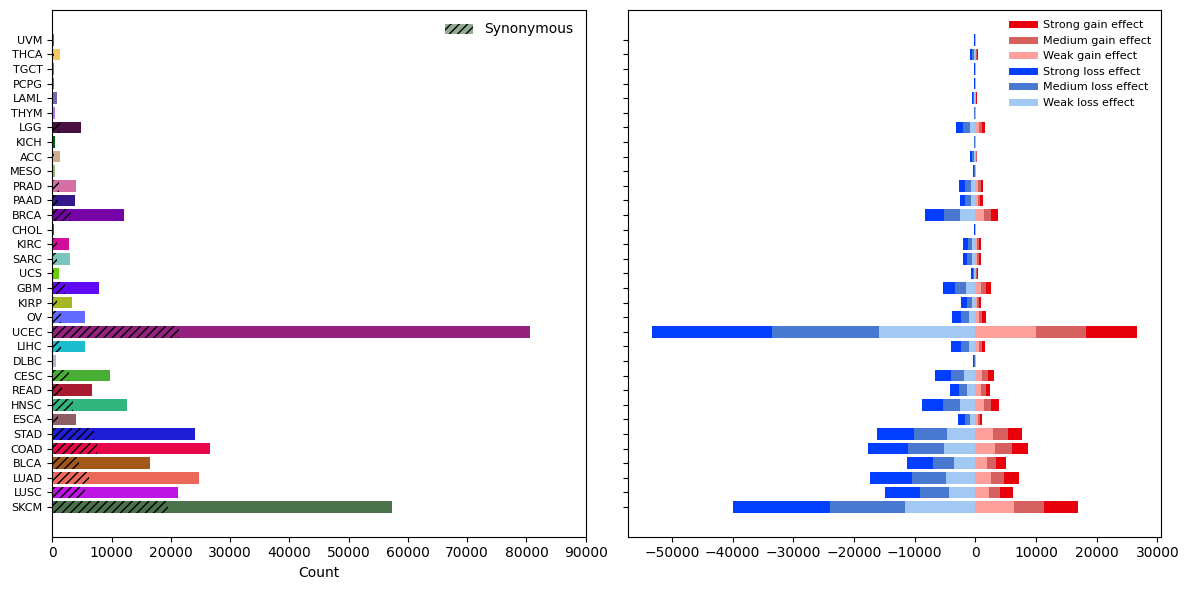

In [4]:
# Create a figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # 1 row, 2 columns

# Left panel: Your existing barh plot
ax[0].barh(category_order, sorted_total, color=order_color)
ax[0].barh(category_order, sorted_syn, color=order_color, edgecolor="black", hatch='////', linewidth=0.0)

ax[0].set_yticks(range(len(category_order)))
ax[0].set_yticklabels(category_order, fontsize=8)
ax[0].set_xticks(ax[0].get_xticks())
ax[0].tick_params(axis='x')

ax[0].set_xlabel('Count')

### fabian
categories_gain = list(dic_cancer_effect_sum_GAIN_reorder.keys())
values_gain = list(dic_cancer_effect_sum_GAIN_reorder.values())

categories_loss = list(dic_cancer_effect_sum_LOSS_reorder.keys())
values_loss = list(dic_cancer_effect_sum_LOSS_reorder.values())

# Create a list of colors for the stacked bars (blue, red, green)
palette_1 = sns.color_palette('bright')
palette_2 = sns.color_palette('muted')
palette_3 = sns.color_palette('pastel')
colors_gain = [palette_3[3],palette_2[3],palette_1[3]]
colors_loss = [palette_3[0],palette_2[0],palette_1[0]]

# Initialize the bottom values for each category and create the stacked bar plot

bottom = [0] * len(categories_gain)
for i in range(3):  # Loop for each value in the lists
    value = [values_gain[j][i] for j in range(len(categories_gain))]
    ax[1].barh(categories_gain, value, color=colors_gain[i], left=bottom)
    bottom = [bottom[j] + value[j] for j in range(len(categories_gain))]

bottom = [0] * len(categories_gain)
for i in range(3):  #loss plot
    value = [values_loss[j][i] for j in range(len(categories_loss))]
    ax[1].barh(categories_loss, value, color=colors_loss[i], left=bottom)
    bottom = [bottom[j] + value[j] for j in range(len(categories_loss))]

#legend custom
import matplotlib.patches as mpatches
a_val = 0.6
circ1 = mpatches.Patch(facecolor=order_color[0],alpha=a_val,hatch=r'////',label='Synonymous')
ax[0].legend(handles=[circ1], frameon=False)

custom_legend = [
    plt.Line2D([0], [0], color=palette_1[3], lw=5, label='Strong gain effect'),
    plt.Line2D([0], [0], color=palette_2[3], lw=5, label='Medium gain effect'),
    plt.Line2D([0], [0], color=palette_3[3], lw=5, label='Weak gain effect'),
    plt.Line2D([0], [0], color=palette_1[0], lw=5, label='Strong loss effect'),
    plt.Line2D([0], [0], color=palette_2[0], lw=5, label='Medium loss effect'),
    plt.Line2D([0], [0], color=palette_3[0], lw=5, label='Weak loss effect'),
]
plt.legend(handles=custom_legend, frameon=False, fontsize=8)

#rest
plt.ylabel(None)
plt.yticks(None)

plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/supplementary_figures/supp_fig6/tcga_count_fabian.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/tls1/supplementary_figures/supp_fig6/tcga_count_fabian.png", format="png", bbox_inches="tight", dpi=450)

plt.show()
